In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization, Embedding, Conv1D, MaxPool1D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [2]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [3]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [4]:
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data,y_data)

In [5]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [64]:
# # 重置数据维度
# print(x_train.shape)
# x_train = x_train.reshape(-1,1,x_train.shape[-1])
# x_test = x_test.reshape(-1,1,x_test.shape[-1])
# print(x_train.shape)

(1777, 2000)
(1777, 1, 2000)


In [6]:
# 对类别数据进行onehot编码
print(y_train.shape)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(y_train.shape)

(1777,)
(1777, 2)


In [9]:
# 构建网络
model = Sequential()
model.add(Embedding(input_dim=21, input_length=2000, output_dim=128))
model.add(Conv1D(128,16, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPool1D(pool_size=5,strides=5))

model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu')))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         2688      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1985, 128)         262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1985, 128)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 397, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 397, 128)          98816     
_________________________________________________________________
batch_normalization_3 (Batch (None, 397, 128)          512       
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)              

In [10]:
# 训练网络
epochs = 100 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V10_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8030
Epoch 00001: val_accuracy improved from -inf to 0.53708, saving model to BiLSTM_V10_2.h5
28/28 [==============================] - 89s 3s/step - loss: 0.4525 - accuracy: 0.8030 - val_loss: 0.6606 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8739
Epoch 00002: val_accuracy improved from 0.53708 to 0.86067, saving model to BiLSTM_V10_2.h5
28/28 [==============================] - 86s 3s/step - loss: 0.3151 - accuracy: 0.8739 - val_loss: 0.6206 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.8942
Epoch 00003: val_accuracy did not improve from 0.86067
28/28 [==============================] - 87s 3s/step - loss: 0.2580 - accuracy: 0.8942 - val_loss: 0.5909 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 

28/28 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9910
Epoch 00028: val_accuracy did not improve from 0.88315
28/28 [==============================] - 84s 3s/step - loss: 0.0218 - accuracy: 0.9910 - val_loss: 3.5347 - val_accuracy: 0.5191 - lr: 5.0000e-04
Epoch 29/100
28/28 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9989
Epoch 00029: val_accuracy did not improve from 0.88315
28/28 [==============================] - 84s 3s/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 1.6836 - val_accuracy: 0.6607 - lr: 5.0000e-04
Epoch 30/100
28/28 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9977
Epoch 00030: val_accuracy did not improve from 0.88315
28/28 [==============================] - 84s 3s/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 2.4828 - val_accuracy: 0.5955 - lr: 5.0000e-04
Epoch 31/100
28/28 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9994
Epoch 00031: val_accuracy 

28/28 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994
Epoch 00055: val_accuracy did not improve from 0.88315
28/28 [==============================] - 182s 6s/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 2.4645 - val_accuracy: 0.6337 - lr: 2.5000e-04
Epoch 56/100
28/28 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.88315
28/28 [==============================] - 182s 6s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.0450 - val_accuracy: 0.5978 - lr: 2.5000e-04
Epoch 57/100
28/28 [==============================] - ETA: 0s - loss: 5.6090e-04 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.88315
28/28 [==============================] - 179s 6s/step - loss: 5.6090e-04 - accuracy: 1.0000 - val_loss: 2.7452 - val_accuracy: 0.6135 - lr: 2.5000e-04
Epoch 58/100
28/28 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9994
Epoch 00058: va

28/28 [==============================] - ETA: 0s - loss: 6.5197e-04 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.88315
28/28 [==============================] - 83s 3s/step - loss: 6.5197e-04 - accuracy: 1.0000 - val_loss: 2.6421 - val_accuracy: 0.6000 - lr: 1.2500e-04
Epoch 83/100
28/28 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.88315
28/28 [==============================] - 81s 3s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.4337 - val_accuracy: 0.6090 - lr: 1.2500e-04
Epoch 84/100
28/28 [==============================] - ETA: 0s - loss: 6.9009e-04 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.88315
28/28 [==============================] - 81s 3s/step - loss: 6.9009e-04 - accuracy: 1.0000 - val_loss: 2.5761 - val_accuracy: 0.6045 - lr: 1.2500e-04
Epoch 85/100
28/28 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994
Epoch 0008

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


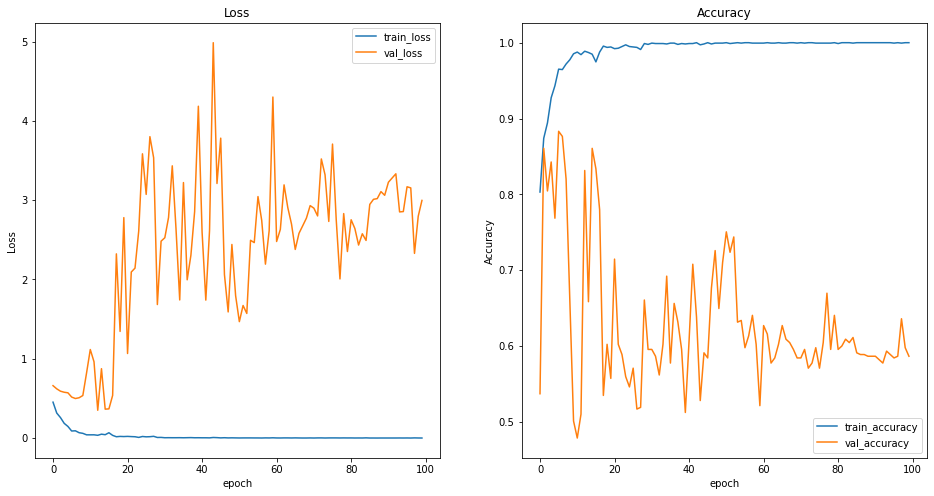

In [11]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [12]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V10_2.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [13]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 0.9207% 召回率: 0.8979357798165137, f1: 0.9173989455184535
在20%测试集上, accuracy: 0.8831% 召回率: 0.8828451882845189, f1: 0.890295358649789


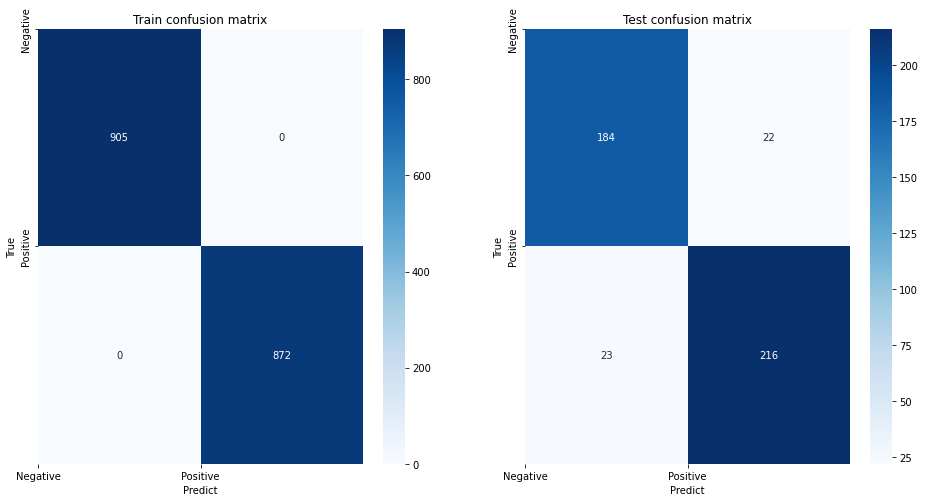

In [17]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()